In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

df = 'detecciones_alevines.csv'
data = pd.read_csv(df, sep=',')

data.head()

,timestamp,class,confidence,X1,Y1,X2,Y2
0,2024-03-13 11:44:46,Alevin,tensor(1.),tensor(523.0328),tensor(353.5459),tensor(607.1686),tensor(445.1391)
1,2024-03-13 11:44:46,Alevin,tensor(1.),tensor(535.2184),tensor(362.7237),tensor(621.2850),tensor(457.5335)
2,2024-03-13 11:44:47,Alevin,tensor(1.),tensor(537.7475),tensor(363.7668),tensor(622.9311),tensor(459.1210)
3,2024-03-13 11:44:47,Alevin,tensor(1.),tensor(538.2437),tensor(364.2957),tensor(623.9667),tensor(459.8684)
4,2024-03-13 11:44:47,Alevin,tensor(2.),tensor(604.6559),tensor(236.3149),tensor(632.1202),tensor(349.0140)


In [2]:
data.describe()

,timestamp,class,confidence,X1,Y1,X2,Y2
count,1470,1470,1470,1470,1470,1470,1470
unique,72,1,13,1467,1467,1469,1466
top,2024-03-13 11:45:05,Alevin,tensor(11.),tensor(503.5703),tensor(358.9282),tensor(602.0403),tensor(480.)
freq,31,1470,451,2,2,2,3


In [3]:
#Limpieza de datos
tensor_columns = ['confidence', 'X1', 'Y1', 'X2', 'Y2']
for column in tensor_columns:
    data[column] = data[column].str.extract(r'tensor\((.*?)\)').astype(float)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [4]:
#Calculo de centroides
data['X_center'] = (data['X1'] + data['X2']) / 2
data['Y_center'] = (data['Y1'] + data['Y2']) / 2

In [5]:
#Funcion para Calcular la distancia promedio entre alevines
def calculo_distancia_promedio(group):
    if len(group) > 1:
        coordinates = group[['X_center', 'Y_center']].values
        distances = pdist(coordinates, metric='euclidean')
        average_distance = distances.mean()
    else:
        average_distance = 0
    return average_distance

#Aplicacion de la funcion para cada timestamp
calculo_distancia_promedio = data.groupby('timestamp').apply(calculo_distancia_promedio)

In [6]:
calculo_distancia_promedio.head()

timestamp
2024-03-13 11:44:46    17.008491
2024-03-13 11:44:47    67.128517
2024-03-13 11:44:48    56.008926
2024-03-13 11:44:49    25.604704
2024-03-13 11:44:50    64.090043
dtype: float64

In [7]:
#Clasificacion de distancias
lower_threshold = calculo_distancia_promedio.quantile(0.33)
upper_threshold = calculo_distancia_promedio.quantile(0.66)

In [8]:
def clasificacion_distancia(distance):
    if distance <= lower_threshold:
        return 'Agrupados'
    elif distance <= upper_threshold:
        return 'Distanciados'
    else:
        return 'Erraticos'
    
Categorias_de_distancia = calculo_distancia_promedio.apply(clasificacion_distancia)
Categorias_de_distancia.head(100)

timestamp
2024-03-13 11:44:46       Agrupados
2024-03-13 11:44:47       Agrupados
2024-03-13 11:44:48       Agrupados
2024-03-13 11:44:49       Agrupados
2024-03-13 11:44:50       Agrupados
                           ...     
2024-03-13 11:45:53       Erraticos
2024-03-13 11:45:54       Erraticos
2024-03-13 11:45:55       Erraticos
2024-03-13 11:45:56    Distanciados
2024-03-13 11:45:57       Erraticos
Length: 72, dtype: object

In [9]:
df_final = pd.DataFrame({
    'timestamp': calculo_distancia_promedio.index,
    'distancia_promedio': calculo_distancia_promedio.values,
    'clasificacion': Categorias_de_distancia.values
})
print(df_final.head())

            timestamp  distancia_promedio clasificacion
0 2024-03-13 11:44:46           17.008491     Agrupados
1 2024-03-13 11:44:47           67.128517     Agrupados
2 2024-03-13 11:44:48           56.008926     Agrupados
3 2024-03-13 11:44:49           25.604704     Agrupados
4 2024-03-13 11:44:50           64.090043     Agrupados


In [10]:
#preparar y dividir los datos en conjunto de entrenamiento y prueba
x = df_final[['distancia_promedio']]
y = df_final['clasificacion']   

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [11]:
#Entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [12]:
#Predecir las etiquetas para el conjunto de prueba
y_pred = knn.predict(x_test)

In [13]:
#Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(1.0,
 '              precision    recall  f1-score   support\n\n   Agrupados       1.00      1.00      1.00        10\nDistanciados       1.00      1.00      1.00         7\n   Erraticos       1.00      1.00      1.00         5\n\n    accuracy                           1.00        22\n   macro avg       1.00      1.00      1.00        22\nweighted avg       1.00      1.00      1.00        22\n')

In [14]:
#Matriz de confusion
cm = confusion_matrix(y_test, y_pred)
classes = ['Agrupados', 'Distanciados', 'Erraticos']

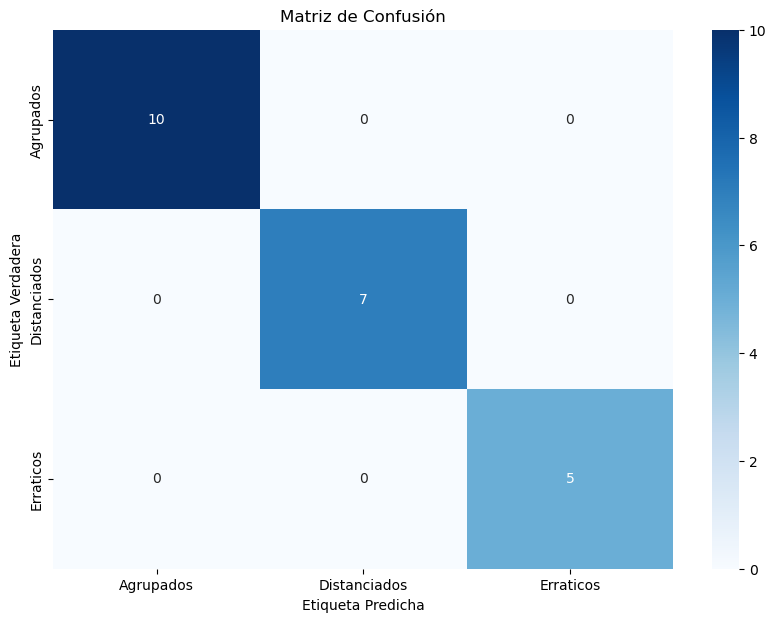

In [15]:
#graficar la matriz de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

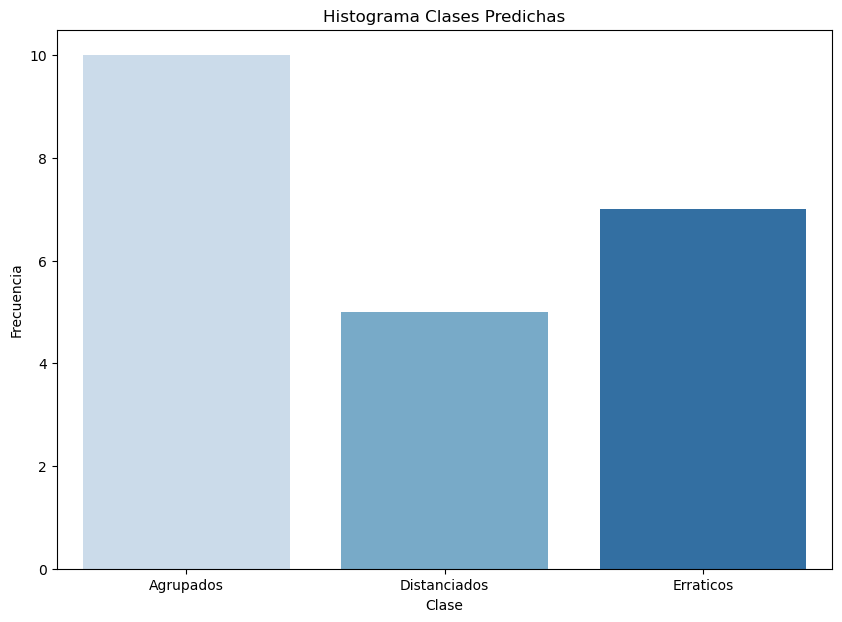

In [17]:
#Graficar el histograma de las clases predichas
plt.figure(figsize=(10, 7))
sns.countplot(x= y_pred, palette='Blues')
plt.title('Histograma Clases Predichas')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(range(len(classes)), classes)
plt.show()

In [18]:
#guardar modelo knn
import joblib

joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']